
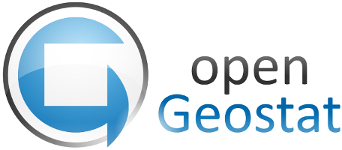

In [1]:
import gamv
import pygslib
import pandas as pd
import numpy as np

In [2]:
data = pygslib.gslib.read_gslib_file('../pygslib/data/cluster.dat')

In [3]:
data['Zlocation']= 0.0
data['Domain'] = 0
data.head()

,Xlocation,Ylocation,Primary,Secondary,Declustering Weight,Zlocation,Domain
0,39.5,18.5,0.06,0.22,1.619,0.0,0
1,5.5,1.5,0.06,0.27,1.619,0.0,0
2,38.5,5.5,0.08,0.40,1.416,0.0,0
3,20.5,1.5,0.09,0.39,1.821,0.0,0
4,27.5,14.5,0.09,0.24,1.349,0.0,0


In [40]:
#-----------------------------------------------------------------------------------------------------------------
#
#    Variograms GAMV low level functions
#
#-----------------------------------------------------------------------------------------------------------------

def gamv(parameters):
    """Calculate experimental variograms on sparse data

    This function is similar to the GSLIB gamv function but with some minor differences:

     - the indicator automatic transformation is not applied; you may define
       indicator variables externally.
     - a bhid variable is always required, to avoid downhole variogram use
       ``bhid=None`` or ``bhid = 0``.
     - Z variable is required, you can use constant coordinate to reduce
       dimensions, for example use Z=None in the parameter file or
       Z = 0 in the file.
     - The variogram cloud was implemented but it only works for the first
       variogram and first direction. It only works for some variogram types.


    Parameters
    ----------
        parameters  :  dict
            dictionary with calculation parameters

    The dictionary with parameters may be as follows::


            parameters = {
                    'data'   :  data,          # Pandas dataframe
                    'columns':  ['X','Y','Z','BHID'],  # X,Y,Z, and BHID column names
                    'vr'     :  ['v1','v2'],            # Variables names 
                    'tmin'   : -1.0e21,        # trimming limits, float, if None or basent = -1.0e21
                    'tmax'   :  1.0e21,        # trimming limits, float, if None or basent = 1.0e21
                    'nlag'   :  10,            # number of lags, int
                    'xlag'   :  4,             # lag separation distance, float
                    'xltol'  :  2,             # lag tolerance, float
                    'azm'    : [0,0,90],       # azimuth, array('f') with bounds (ndir)
                    'atol'   : [90,22.5,22.5], # azimuth tolerance, array('f') with bounds (ndir)
                    'bandwh' : [50,10,10],     # bandwidth 'horizontal', array('f') with bounds (ndir)
                    'dip'    : [0,0,0],        # dip, array('f') with bounds (ndir)
                    'dtol'   : [10,10,10],     # dip tolerance, array('f') with bounds (ndir)
                    'bandwd' : [10,10,10],     # bandwidth 'vertical', array('f') with bounds (ndir)
                    'isill'  : 0,              # standardize sills? (0=no, 1=yes), int
                    'sills'  : [100],          # variance used to std the sills, array('f') with bounds (nv)
                    'ivtail' : [1,1,1,1,1,1,1],# tail var., array('i') with bounds (nvarg), nvarg is number of variograms
                    'ivhead' : [1,1,1,1,1,1,1],# head var., array('i') with bounds (nvarg)
                    'ivtype' : [1,1,1,1,1,1,1],# variogram type, array('i') with bounds (nvarg)
                    'maxclp' : 50000}          # maximum number of variogram point cloud to use, input int

    Warnings
    --------
    bhid must be an array of integers

    Returns
    -------
       pdis :  Distance of pairs falling into this lag
       pgam :  Semivariogram, covariance, correlogram,... value
       phm  :  Mean of the tail data
       ptm  :  Mean of the head data
       phv  :  Variance of the tail data
       ptv  :  Variance of the head data
       pnump:  Number of pairs
       cldi :  data index of the head
       cldj :  data index of the tail
       cldg :  Semivariogram, covariance, ... value
       cldh :  Distance of each pair


    Note
    -----
    The output variables with prefix *cld* are for variogram cloud and
    with prefix *p* are for directional variograms

    The variables with prefix *p* are similar to the output generated
    by the GSLIB standalone program **gamv**.

    The variogram cloud only works for the first variogram/direction
    and only if the variogram of type 1, 2, 6, 7 and 8.

    The variogram types are:

     - traditional semivariogram (1)
     - traditional cross semivariogram (2)
     - pairwise relative semivariogram (6)
     - semivariogram of logarithms (7)
     - semimadogram(8)

    """
    
    assert (len(parameters['vr'])==len(parameters['sills'])) # make sure the number of dimmensions is right
    for i in parameters['ivtype']:
        assert (i>=0 and i<=8)
    
    newpar = {}
    newpar['x'] = parameters['data'][parameters['columns'][0]].values
    newpar['y'] = parameters['data'][parameters['columns'][1]].values
    newpar['z'] = parameters['data'][parameters['columns'][2]].values
    newpar['bhid'] = parameters['data'][parameters['columns'][3]].values
    newpar['vr'] = parameters['data'][parameters['vr']].values
    if 'tmin' in parameters:
        if parameters['tmin'] is not None:
            newpar['tmin'] = parameters['tmin']
        else:
            newpar['tmin'] = -1.0e21
    else:
        newpar['tmin'] = -1.0e21
        
    if 'tmax' in parameters:
        if parameters['tmax'] is not None:
            newpar['tmax'] = parameters['tmax']
        else:
            newpar['tmax'] = 1.0e21
    else:
        newpar['tmin'] = -1.0e21  
    
    
    
    newpar['nlag'] = parameters['nlag'] 
    newpar['xlag'] = parameters['xlag'] 
    newpar['xltol'] = parameters['xltol'] 
    newpar['azm'] = parameters['azm'] 
    newpar['atol'] = parameters['atol'] 
    newpar['bandwh'] = parameters['bandwh'] 
    newpar['dip'] = parameters['dip'] 
    newpar['dtol'] = parameters['dtol'] 
    newpar['bandwd'] = parameters['bandwd']
    newpar['isill'] = parameters['isill'] 
    newpar['sills'] = parameters['sills'] 
    newpar['ivtail'] = parameters['ivtail']    
    newpar['ivhead'] = parameters['ivhead'] 
    newpar['ivtype'] = parameters['ivtype']
    newpar['maxclp'] = parameters['maxclp']
    
    npt,dis, gam, hm, tm, hv, tv, cldi, cldj, cldg, cldh, l = pygslib.gslib.__variograms.gamv(**newpar)

    if l==parameters['maxclp']:
        warnings.warn( 'Warning: l == maxclp; maximum number ' + \
                       'of point clouds reached, increase maxclp' + \
                       'or modify variogram parameters')

    #remove crap data from variogram cloud
    cldi=cldi[:l]
    cldj=cldj[:l]
    cldg=cldg[:l]
    cldh=cldh[:l]

    # get output like in gslib

    ndir = len(parameters['azm'])
    nvarg = len(parameters['ivtype'])
    nlag = parameters['nlag']


    pdis,pgam, phm,ptm,phv,ptv,pnump = pygslib.gslib.__variograms.writeout(nvarg,ndir,nlag,npt,dis,gam,hm,tm,hv,tv)
    
    # each is an array of (nvarg, ndir, nlag+2)
    lag = []
    azm = []
    dip = []
    vtail= []
    vhead= []
    vtype= []
    dirID = []
    vrgID = []
    for ivr in range(nvarg):
        for idr in range(ndir):
            
            lag.append(0)
            lag.append(0.5)
            
            azm.append(parameters['azm'][idr])
            dip.append(parameters['dip'][idr])
            azm.append(parameters['azm'][idr])
            dip.append(parameters['dip'][idr])
            
            vtail.append(parameters['vr'][parameters['ivtail'][ivr]-1])
            vhead.append(parameters['vr'][parameters['ivhead'][ivr]-1])
            vtype.append(parameters['ivtype'][ivr])
            vtail.append(parameters['vr'][parameters['ivtail'][ivr]-1])
            vhead.append(parameters['vr'][parameters['ivhead'][ivr]-1])
            vtype.append(parameters['ivtype'][ivr])   
            
            dirID.append(idr)
            vrgID.append(ivr)
            dirID.append(idr)
            vrgID.append(ivr)            
            
            
            for ilg in range(2,nlag+2):
                lag.append(ilg-1)
                azm.append(parameters['azm'][idr])
                dip.append(parameters['dip'][idr])
                vtail.append(parameters['vr'][parameters['ivtail'][ivr]-1])
                vhead.append(parameters['vr'][parameters['ivhead'][ivr]-1])
                vtype.append(parameters['ivtype'][ivr])
                dirID.append(idr)
                vrgID.append(ivr)
                
                
    vtab = pd.DataFrame(
        {
            'Dip dir': azm,
            'Dip': dip,
            'Head' : vhead,
            'Tail' : vtail,
            'Lag distance': pdis.ravel()*0.0,
            'X': pdis.ravel()*0.0,
            'Y': pdis.ravel()*0.0,
            'Z': pdis.ravel()*0.0,
            'Average distance': pdis.ravel(), 
            'Spatial function value': pgam.ravel(), 
            'Spatial function type' : vtype,
            'Mean head': phm.ravel(),
            'Mean tail': ptm.ravel(),
            'Variance head': phv.ravel(),
            'Variance tail': ptv.ravel(),
            'Number of pairs': pnump.ravel(),
            'Varg ID': vrgID,
            'Dir ID': dirID,
            'Lag': lag,
        }
    )

    DEG2RAD=3.14159265/180.0
    
    vtab['Lag distance'] = vtab['Lag']*parameters['xlag'] 
    vtab['X'] = np.sin(DEG2RAD*vtab['Dip dir'])*np.cos(DEG2RAD*vtab['Dip'])*vtab['Lag distance'] 
    vtab['Y'] = np.cos(DEG2RAD*vtab['Dip dir'])*np.cos(DEG2RAD*vtab['Dip'])*vtab['Lag distance']
    vtab['Z'] =                                 np.sin(DEG2RAD*vtab['Dip'])*vtab['Lag distance'] 
    
    vtab.loc[vtab['Lag distance']==0, 'Spatial function value']=np.nan
    
    cloud = pd.DataFrame(
        {
           'Index head': cldi, 
           'Index tail': cldj,
           'Spatial function value': cldg,  
           'Distance': cldh  
        }
    )
    
    return vtab, cloud

In [96]:
tol = 10 
azm = np.arange(0,180,10)
atol = np.ones(azm.shape)*tol*4
bandwh = np.ones(azm.shape)*100000
dip = np.ones(azm.shape)*0
dtol = np.ones(azm.shape)*45
bandwd = np.ones(azm.shape)*100000
 
parameters = {
        'data'   :  data,          # Pandas dataframe
        'columns':  ['Xlocation','Ylocation','Zlocation','Domain'],  # X,Y,Z, and BHID column names
        'vr'     :  ['Primary','Secondary'],            # Variables names 
        'tmin'   : -1.0e21,        # trimming limits, float, if None or basent = -1.0e21
        'tmax'   :  1.0e21,        # trimming limits, float, if None or basent = 1.0e21
        'nlag'   :  10,            # number of lags, int
        'xlag'   :  4,             # lag separation distance, float
        'xltol'  :  2,             # lag tolerance, float
        'azm'    : azm,       # azimuth, array('f') with bounds (ndir)
        'atol'   : atol, # azimuth tolerance, array('f') with bounds (ndir)
        'bandwh' : bandwh,     # bandwidth 'horizontal', array('f') with bounds (ndir)
        'dip'    : dip,        # dip, array('f') with bounds (ndir)
        'dtol'   : dtol,     # dip tolerance, array('f') with bounds (ndir)
        'bandwd' : bandwd,     # bandwidth 'vertical', array('f') with bounds (ndir)
        'isill'  : 1,              # standardize sills? (0=no, 1=yes), int
        'sills'  : [100, 200],          # variance used to std the sills, array('f') with bounds (nv)
        'ivtail' : [1],# tail var., array('i') with bounds (nvarg), nvarg is number of variograms
        'ivhead' : [1],# head var., array('i') with bounds (nvarg)
        'ivtype' : [4],# variogram type, array('i') with bounds (nvarg)
        'maxclp' : 50000}          # maximum number of variogram point cloud to use, input int

In [97]:
np.linspace(0,180,10)

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.])

In [98]:
vtab, cloud= gamv(parameters)

In [99]:
vtab.head()

,Dip dir,Dip,Head,Tail,Lag distance,X,Y,Z,Average distance,Spatial function value,Spatial function type,Mean head,Mean tail,Variance head,Variance tail,Number of pairs,Varg ID,Dir ID,Lag
0,0,0.0,Primary,Primary,0.0,0.0,0.0,0.0,0.000000,NaN,4,4.350429,4.350429,44.924286,44.924286,140,0,0,0.0
1,0,0.0,Primary,Primary,2.0,0.0,2.0,0.0,1.394737,0.191364,4,7.801579,8.018684,19.380919,36.205985,38,0,0,0.5
2,0,0.0,Primary,Primary,4.0,0.0,4.0,0.0,4.450606,0.104319,4,7.817067,6.424178,110.284895,62.408205,225,0,0,1.0
3,0,0.0,Primary,Primary,8.0,0.0,8.0,0.0,8.044660,0.053549,4,3.798731,5.689396,18.300612,70.934908,331,0,0,2.0
4,0,0.0,Primary,Primary,12.0,0.0,12.0,0.0,11.876218,0.134359,4,3.578981,5.557083,20.887444,75.829249,432,0,0,3.0


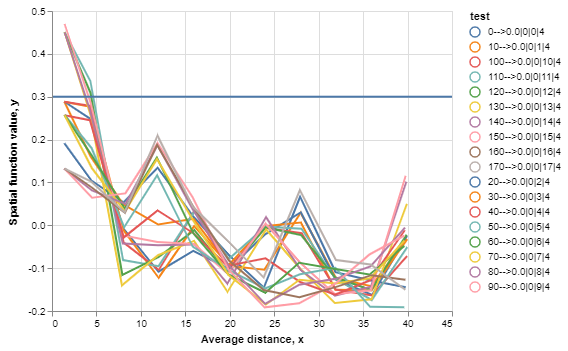

In [100]:
import altair as alt
alt.renderers.enable('default')

vtab['tmp'] = '-->'
vtab['tmp2'] = '|'
vtab['test'] = vtab['Dip dir'].astype(str) + vtab['tmp'] + vtab['Dip'].astype(str) + \
               vtab['tmp2'] + vtab['Varg ID'].astype(str) + \
               vtab['tmp2'] + vtab['Dir ID'].astype(str) + \
               vtab['tmp2'] + vtab['Spatial function type'].astype(str) 

alt.Chart(vtab).mark_line().encode(
    x='Average distance',
    y='Spatial function value',
    color='test',
    tooltip = 'Number of pairs'
) + \
alt.Chart(pd.DataFrame({'x':[0,45],'y':[0.3,.3]})).mark_line().encode(
    x='x',
    y='y'
)


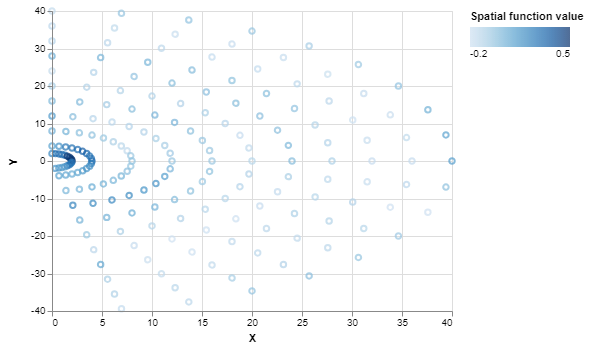

In [102]:
alt.Chart(vtab).mark_point().encode(
    x='X',
    y='Y',
    color='Spatial function value'
)

In [95]:
np.arange(0,180,10)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170])